# Spectrum Overlay

This Jupyter notebook is designed to plot calculated and experimental spectra of all sorts. It can plot harmonic and anharmonic IR, VCD, Raman, and UV-Vis spectra, and overlay these with experimental data from any format.

## Imports

First we need to import a few things. If any of these fail, install them using `pip3` like so:

`pip3 install --user <package>`

In [1]:
import webmo                    # for WebMO interfacing
import numpy as np              # for vector math
import math                     # for square root and log
import matplotlib.pyplot as plt # to make plots at the end
import scipy                    # to calculate line shapes
import itertools                # for iterators
import os                       # deal with files existing
import datetime                 # to timestamp images in case of overwrites

## User Input

Set your user input, along with all the configurable parameters. You'll have to run the jobs to plot on 
your own, though! 

Setting any parameter to `None` will automatically set it to the default later on. Defaults are defined in the comments above each parameter, or you can find them all in the block of code at the end that check for each of them.

In [2]:
## BOOKKEEPING PARAMETERS

# the URL of your WebMO instance
URL = "https://server.university.edu/~webmo/cgi-bin/webmo/rest.cgi"

# your WebMO username
uname = "cbrzezinski"

# List of jobs to pull from. It takes 3-tuples of the form (job #, spectra type, label), where
# spectra type is one of {"IR", "VCD", "RAMAN", "IR_ANHARMONIC", "VCD_ANHARMONIC", "UV_VIS"}. 
# Leave `label` as None to use the WebMO job title.
jobs = [
    # Example:
    (56, "IR", "Ab-Initio Calculation")
]

# The output file to save the results to. If left as `None`, won't save image, just display it.
# We highly recommend saving the image and viewing it that way as the inline Jupyter image display
# is rather low resolution. This notebook WILL NOT overwrite your images; if you were to run the 
# same analysis again it will instead be to "[name]_TIMESTAMP.[ext]" instead so you don't accidentally
# lose data.
output_file = "webmo_output.png"

# Graph ranges for the views. Values are required; no default given.
xrange = (4000,0)
yrange = (0,3)

# Peak width, specified as a Full Width Half Max (FWHM). Default is 40.
peak_width = 40

# Resolution for the plot itself (or how many points are calculated for the predicted spectrum). Default is 4000.
resolution = 8000

# If you want a frequency scaling factor, which only applies to certain spectra types. 
# Default is 1.00. For B3LYP/6-31G(d) IR spectra, you would want 0.96.
scaling_factor = None

# The labels for the plot. Defaults are empty.
xlabel = "Wavenumber"
ylabel = "Absorption"

# The title of the output. Default is no title.
title = None

# `True` if the generated plot should only be greyscale (e.g., for a publication)
# `False` for color. Default is color.
greyscale = None

# The resolution to save or display the plot at in DPI. Default is 1200.
DPI = None

# Line width of the drawn spectra. Default is 0.5.
plot_line_width = None

# Line shape. Options are gaussian, lorentzian, and voigt (50/50 split). Default is voigt.
lineshape = None

## EXPERIMENTAL PARAMETERS

# Gas Parameters
# Pressure in torr. Default is 10.
pressure = None

# Sample cell pathlength in cm. Default is 10.
clength = None

### Set up `REST` Session

Set up the `REST` session and log into WebMO.

In [3]:
rest = webmo.WebMOREST(URL, username=uname)

Enter WebMO password for user cbrzezinski: ········


### Experimental Data (Optional)

Here's how to overlay some experimental data. Using the cell below as scratch, use whatever method you need to get your experimental data into variables. Then load the variables into the `experimental_jobs` array in the form:
```
(<array of x values>, <array of y values>, "label for the legend on the plot")
```

In [4]:
# Example data in a CSV file of x,y with no headers:
expt_x,expt_y = np.genfromtxt("../csv/data2.csv", delimiter=",", dtype=float,
                             missing_values=0.0, names=None).T

experimental_curves = [
    # format: (x_array, y_array, "label")
    # This is how you would format given the above example:
    (expt_x,expt_y,"Experiment"),
]

### Verification and Defaults

Check that the input makes sense.

In [5]:
if URL[:4] != "http":
    print("Error: Check that your WebMO URL is in fact a URL")

We'll also set any values left as `None` to their defaults here.

In [6]:
if peak_width == None:
    peak_width = 40

if resolution == None:
    resolution = 4000

if scaling_factor == None:
    scaling_factor = 1

if xlabel == None:
    xlabel = ""

if ylabel == None:
    ylabel = ""

if pressure == None:
    pressure = 10

if clength == None:
    clength = 10

if greyscale == None:
    greyscale = False

if plot_line_width == None:
    plot_line_width = 0.5

if greyscale:
    plt.style.use('grayscale')

if lineshape == None:
    lineshape = "voigt"

if DPI == None:
    DPI = 1200

## Job Fetching and Calculations (Recommended)

Grab the data for each job and generate the curves from it.

### Utility Functions

These functions are the building blocks that do the work of a) downloading the correct values from WebMO, and b) calculating
the curves to plot from those values.

In [7]:
def get_frequencies(rest, job, type):
    """
    Retrieve WebMO job information. Here lives all the magic to get the right peak positions and intensities.
    """
    def deref(obj, l):
        """
        Dereference a nested dictionary by a sequence of indices given in a list. Or in other words:
        
        deref(obj, ['a','b','c','d'])
                 <=>
        obj['a']['b']['c']['d']
        """
        k = obj
        for ac in l:
            k = k[ac]

        return k

    # util functions
    identity = lambda x: x
    scale = lambda x: list(map(lambda y: y * scaling_factor,x))

    # accessor shorthands
    FREQ_ACCESSOR = ["properties", "vibrations"]
    ANH_ACCESSOR = ["properties", "anharmonic_vibrations"]

    # this looks scarier than it is. For each type of spectra, we have an accessor to the x values (called
    # points), an accessor to the y values (called intensities), and a function to adjust both of those
    # (called adjp and adji respectively). The correct functions get assigned to those names by tuple assignment
    # through this dictionary, which acts like a switch statement.
    (points, intensities, adjp, adji) = {
        "IR": (
            FREQ_ACCESSOR + ["frequencies"], 
            FREQ_ACCESSOR + ["intensities", "IR"],
            scale,
            lambda x: list(map(lambda Ee: (Ee * (10**5) * clength * pressure * (5.38E-8))/2.303,x))
        ),
        "VCD": (
            FREQ_ACCESSOR + ["frequencies"],
            FREQ_ACCESSOR + ["intensities", "VCD"],
            scale, 
            identity
        ),
        "RAMAN": (
            FREQ_ACCESSOR + ["frequencies"],
            FREQ_ACCESSOR + ["intensities", "raman"],
            identity, 
            identity
        ),
        "IR_ANHARMONIC": (
            ANH_ACCESSOR + ['frequencies'],
            ANH_ACCESSOR + ["intensities", "IR"],
            identity,
            lambda x: list(map(lambda Ee: (Ee * (10**5) * clength * pressure * (5.38E-8))/2.303,x))
        ),
        "VCD_ANHARMONIC": (
            ANH_ACCESSOR + ["frequencies"],
            ANH_ACCESSOR + ["intensities", "VCD"],
            identity,
            identity
        ),
        "UV-VIS": (
            ['properties', 'excited_states', 'transition_energies'],
            ['properties', 'excited_states', 'intensities'],
            identity,
            identity
        )
    }[type.upper()]
    a = rest.get_job_results(job)
    pts = adjp(deref(a,points))
    ints = adji(deref(a,intensities))
    return (pts,ints)

def arb_gaussian(center, intensity):
    """
    Return a gaussian with an arbitrary height and intensity, with sigma being determined by calculating
    it from our FWHM peak width.
    """
    sigma = (peak_width / (2 * math.sqrt(2 * math.log(2))))
    l = lambda x: intensity * (1/sigma*math.sqrt(2*math.pi)) * math.exp(-((x-center)**2/(2*sigma**2)))
    
    return l

def arb_lorentz(center, intensity):
    """
    Return a lorentzian with an arbitrary height and intensity, with gamma being calculated from our
    FWHM peak width.
    """
    gamma = (peak_width / 2)
    l = lambda x: (intensity/math.pi) * (gamma/((x-(center))**2 + gamma**2))
    
    return l
    
def arb_voigt(center, intensity):
    """
    Use the Faddeeva function to calculate a 50/50 voigt line shape. See
    https://en.wikipedia.org/wiki/Voigt_profile#The_uncentered_Voigt_profile and
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.wofz.html
    """
    def voigt_decoder(q, k):
        """
        Takes the FWHM (k) and a ratio (q) and determines the values of gamma␣
        ↪and sigma.
        Accurate to within around 1.2%.
        """
        f_l = (-k*(q**2) + (-1 + q)**2 * np.sqrt(((k**2)*(q**2) * (4 - 8 * q + 5 * (q**2)))/(-1 + q)**4))/(2 * (-1 + q)**2)
        f_g = (k * (q**2) - (-1 + q)**2 * np.sqrt(((k**2) * (q**2) * (4 - 8 * q + 5 * (q**2)))/(-1 + q)**4))/(2 * (-1 + q) * q)
        
        gamma = f_l/2 # because gamma = FWHM/2
        sigma = f_g / (2 * np.sqrt(2*np.log(2)))
        
        return(gamma,sigma)
        
    gamma, sigma = voigt_decoder(0.3, peak_width)
    denom = sigma * math.sqrt(2 * math.pi) # denomonator
    z = lambda x: scipy.special.wofz((x - center + gamma*1j)/(math.sqrt(2) * sigma)) # Define z(x) as numerator, more or less
    l = lambda x: intensity * ((z(x).real)/denom) # define the actual voigt function
    return l

def generate_curve(rest, job, type, axis):
    """
    Given a job, spectra type, and axis to calculate on, calculates the resultant y data.
    """
    (freq, intensity) = get_frequencies(rest, job, type)
    
    arb_curve = {
        "VOIGT": arb_voigt,
        "CAUCHY": arb_lorentz,
        "GAUSSIAN": arb_gaussian,
    }[lineshape.upper()]

    # create our y array of zeroes
    y = np.zeros(axis.shape)

    # loop over the peaks, adding each peak to our y
    for x in range(0, len(freq)):
        # vectorize is faster than looping through axis manually
        vfunc = np.vectorize(arb_curve(freq[x],intensity[x]))
        y += vfunc(axis)

    return y

### Calculate the Predicted Curves

Generate the curves by setting up the numpy arrays and then looping over all of the jobs.

In [8]:
# numpy can't deal with inverse ranges
start = min(xrange[0],xrange[1])
end = max(xrange[0],xrange[1])
res = (end-start)/resolution

# set up np x array as a vector
x = np.arange(start,end,res)

# generate our calculated curves
calc_curves = []
for i in range(0, len(jobs)):
    # jobs[i][0] = job #
    # jobs[i][1] = spectra type
    # jobs[i][2] = label
    y = generate_curve(rest, jobs[i][0], jobs[i][1], x)
    if (jobs[i][2] == None):
        name = rest.get_job_info(jobs[i][0])['properties']['jobName']
    else:
        name = jobs[i][2]
    calc_curves.append((x, y, name))

curves_to_plot = calc_curves + experimental_curves

if not isinstance(curves_to_plot, list):
    raise ValueError("Check that you actually provided a list of plots")
elif curves_to_plot == []:
    raise ValueError("Check that you actually provided a list of plots")

## Display All Curves

Finally, we can display our final image and save it to a file if requested.

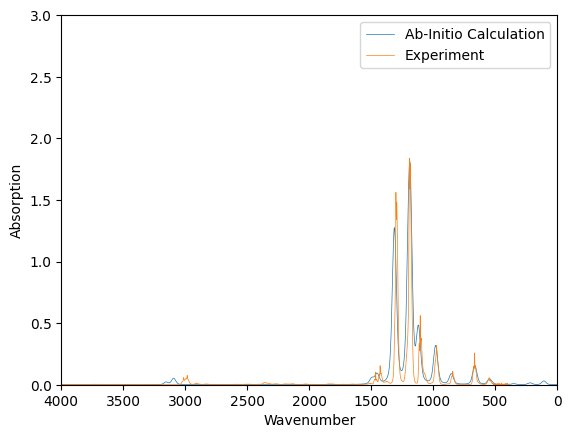

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot *all* the things!
styles = itertools.cycle(['-', '-.', ':', '--'])
fig,ax = plt.subplots() # define here to make greyscale work
for (x,y,label) in curves_to_plot:
    if greyscale:
        ax.plot(x,y, next(styles),
                label=label, 
                linewidth=plot_line_width)
    else:
        ax.plot(x,y, 
                label=label, 
                linewidth=plot_line_width)

# set misc plot options
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axis([xrange[0],xrange[1],yrange[0],yrange[1]])
if title != None:
    plt.title(title)
plt.figure(DPI)
ax.legend()

if output_file != None:
    # check if there's already one
    if os.path.isfile(output_file):
        ext = output_file[-4:]
        name = output_file[:-4]
        new_name = name + "_{:%y%m%d%H%M%S}".format(datetime.datetime.now()) + ext
        fig.savefig(new_name,dpi=DPI)
    else:
        fig.savefig(output_file,dpi=DPI)

plt.show()